#### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql

#### Import Dataset from Database SQL

In [2]:
db = pymysql.connect(host='localhost', user='root', password='', charset='utf8', db='db_forecasting')
cursor = db.cursor()

In [3]:
query = "SELECT * FROM tb_production;"
df = pd.read_sql(query, db)

In [4]:
df.head()

,id,created_at,production
0,1,1962-01-01,589
1,2,1962-02-01,561
2,3,1962-03-01,640
3,4,1962-04-01,656
4,5,1962-05-01,727


In [5]:
df.columns=["id","Date","Production"]

In [6]:
df = df[['Date','Production']]

In [7]:
df.head()

,Date,Production
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727


In [8]:
df.set_index('Date',inplace=True)

In [9]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


#### Plot of The Data, Purpose to Look Distribution of The Data

<AxesSubplot:xlabel='Date'>

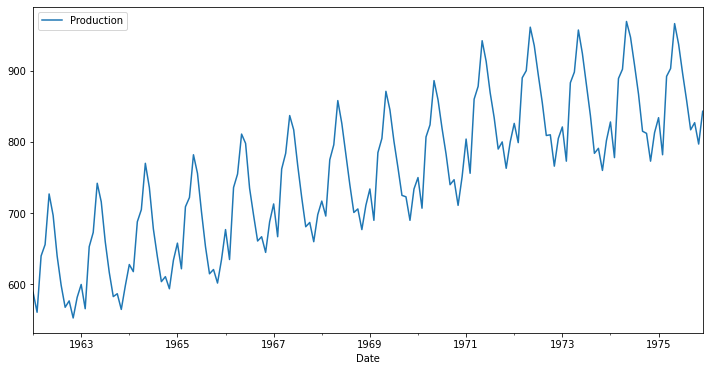

In [10]:
df.plot(figsize=(12,6))

#### Import Decompose Library, Purpose to Look Detail Distribution of The Data

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

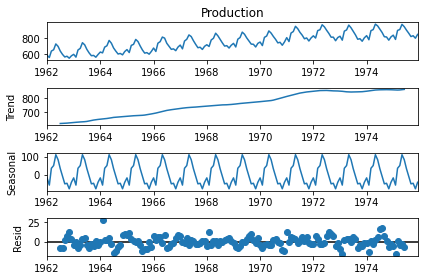

In [12]:
results = seasonal_decompose(df['Production'])
results.plot();

#### Look length of The Data

In [13]:
len(df)

168

#### Split Data Between Train Data and Test Data, with 12 Last Data as a Test Data

In [14]:
train = df.iloc[:156]
test = df.iloc[156:]

#### Import Scaler Library, Purpose to Create Scaler from '0' to '1' for Value of The Data

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [16]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [17]:
df.tail()

,Production
Date,
1975-08-01,858
1975-09-01,817
1975-10-01,827
1975-11-01,797
1975-12-01,843


#### Change Value with Scaler from '0' to '1'

In [18]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [19]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

#### Import Library TimeSeries Generator

In [20]:
from keras.preprocessing.sequence import TimeseriesGenerator

#### Define Generator

In [21]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [22]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [23]:
X.shape

(1, 3, 1)

#### We Do Same Thing, But Now Instead for 12 Months

In [24]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [25]:
X.shape

(1, 3, 1)

#### Import Library LSTM

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [27]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#### Summary of Model

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


#### Fitting Model with Generator

In [29]:
model.fit(generator,epochs=100)

Epoch 1/100
144/144 [==============================] - 3s 4ms/step - loss: 0.0380
Epoch 2/100
144/144 [==============================] - 1s 4ms/step - loss: 0.0197
Epoch 3/100
144/144 [==============================] - 1s 4ms/step - loss: 0.0144
Epoch 4/100
144/144 [==============================] - 1s 4ms/step - loss: 0.0083
Epoch 5/100
144/144 [==============================] - 1s 4ms/step - loss: 0.0071
Epoch 6/100
144/144 [==============================] - 1s 4ms/step - loss: 0.0051A: 0s - los
Epoch 7/100
144/144 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 8/100
144/144 [==============================] - 1s 5ms/step - loss: 0.0051
Epoch 9/100
144/144 [==============================] - 2s 11ms/step - loss: 0.0052
Epoch 10/100
144/144 [==============================] - 6s 41ms/step - loss: 0.0042
Epoch 11/100
144/144 [==============================] - 6s 41ms/step - loss: 0.0048
Epoch 12/100
144/144 [==============================] - 6s 44ms/step - loss: 0.003

144/144 [==============================] - 1s 6ms/step - loss: 0.0014
Epoch 99/100
144/144 [==============================] - 1s 6ms/step - loss: 0.0015
Epoch 100/100
144/144 [==============================] - 1s 6ms/step - loss: 0.0015


#### Plot Fit of Model

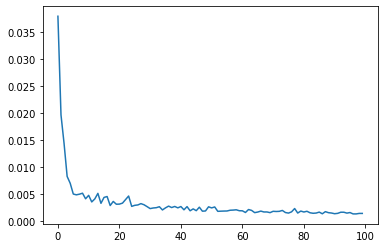

In [30]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [31]:
last_train_batch = scaled_train[-12:]

In [32]:
last_train_batch

array([[0.66105769],
       [0.54086538],
       [0.80769231],
       [0.83894231],
       [1.        ],
       [0.94711538],
       [0.85336538],
       [0.75480769],
       [0.62980769],
       [0.62259615],
       [0.52884615],
       [0.625     ]])

In [33]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [34]:
last_train_batch

array([[[0.66105769],
        [0.54086538],
        [0.80769231],
        [0.83894231],
        [1.        ],
        [0.94711538],
        [0.85336538],
        [0.75480769],
        [0.62980769],
        [0.62259615],
        [0.52884615],
        [0.625     ]]])

In [35]:
model.predict(last_train_batch)

array([[0.66245484]], dtype=float32)

In [36]:
scaled_test[0]

array([0.67548077])

In [37]:
test_predictions = []

In [38]:
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [39]:
for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [40]:
test_predictions

[array([0.66245484], dtype=float32),
 array([0.622741], dtype=float32),
 array([0.8040496], dtype=float32),
 array([0.84645224], dtype=float32),
 array([0.9588256], dtype=float32),
 array([0.92682934], dtype=float32),
 array([0.8578954], dtype=float32),
 array([0.74750566], dtype=float32),
 array([0.6440354], dtype=float32),
 array([0.609123], dtype=float32),
 array([0.5583368], dtype=float32),
 array([0.6160178], dtype=float32)]

#### Data Actual

In [41]:
test

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966
1975-06-01,937
1975-07-01,896
1975-08-01,858
1975-09-01,817


#### Inverse Scaler Value to Absolute Calue on Prediction Value

In [42]:
true_predictions = scaler.inverse_transform(test_predictions)

#### Adding Value Prediction Column on Production Data

In [43]:
test['Predictions'] = true_predictions

<ipython-input-43-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [44]:
test

,Production,Predictions
Date,,
1975-01-01,834,828.581215
1975-02-01,782,812.060249
1975-03-01,892,887.484638
1975-04-01,903,905.124130
1975-05-01,966,951.871445
1975-06-01,937,938.561005
1975-07-01,896,909.884476
1975-08-01,858,863.962357
1975-09-01,817,820.918726


#### Plot Between Production and Prediction Value

<AxesSubplot:xlabel='Date'>

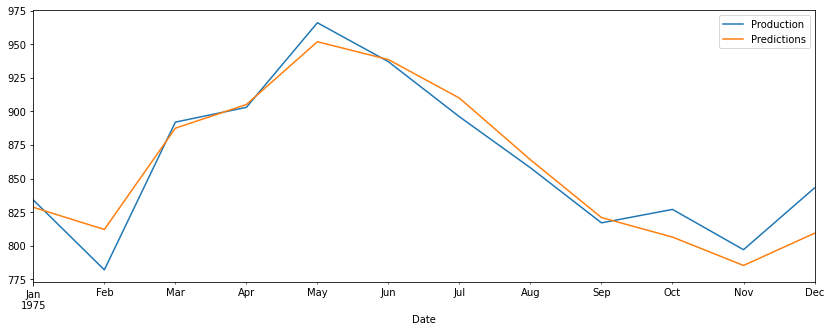

In [45]:
test.plot(figsize=(14,5))

#### Import Library RMSE, Purpose to Check How Many Error Between Production and Prediction

In [46]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [47]:
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

16.08304940564565


#### Ploting Forecasting Analysis

In [48]:
actual_data = df

In [49]:
actual_data

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


<AxesSubplot:xlabel='Date'>

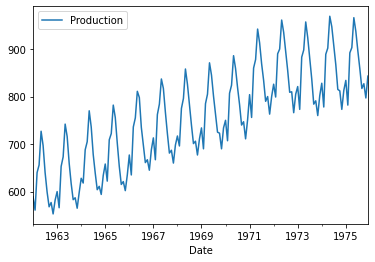

In [50]:
actual_data.plot()

In [51]:
train

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1974-08-01,867
1974-09-01,815
1974-10-01,812


In [52]:
test

,Production,Predictions
Date,,
1975-01-01,834,828.581215
1975-02-01,782,812.060249
1975-03-01,892,887.484638
1975-04-01,903,905.124130
1975-05-01,966,951.871445
1975-06-01,937,938.561005
1975-07-01,896,909.884476
1975-08-01,858,863.962357
1975-09-01,817,820.918726


In [53]:
test2 = test['Predictions']

In [54]:
len(train)

156

In [55]:
len(test2)

12

In [56]:
df['Prediction'] = test2

In [57]:
df

,Production,Prediction
Date,,
1962-01-01,589,NaN
1962-02-01,561,NaN
1962-03-01,640,NaN
1962-04-01,656,NaN
1962-05-01,727,NaN
...,...,...
1975-08-01,858,863.962357
1975-09-01,817,820.918726
1975-10-01,827,806.395164


<AxesSubplot:xlabel='Date'>

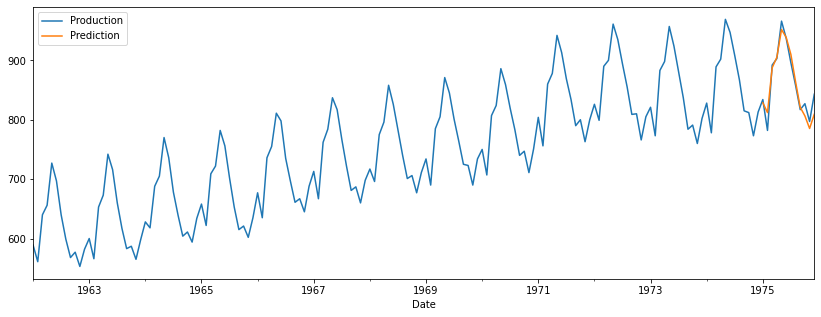

In [58]:
df.plot(figsize=(14,5))

In [59]:
data_prod_predict_last_12 = pd.concat([train,test2])

In [60]:
data_prod_predict_last_12

,Production,0
Date,,
1962-01-01,589.0,NaN
1962-02-01,561.0,NaN
1962-03-01,640.0,NaN
1962-04-01,656.0,NaN
1962-05-01,727.0,NaN
...,...,...
1975-08-01,NaN,863.962357
1975-09-01,NaN,820.918726
1975-10-01,NaN,806.395164


In [61]:
data_prod_predict_last_12.columns = ['Production', 'Prediction']

<AxesSubplot:xlabel='Date'>

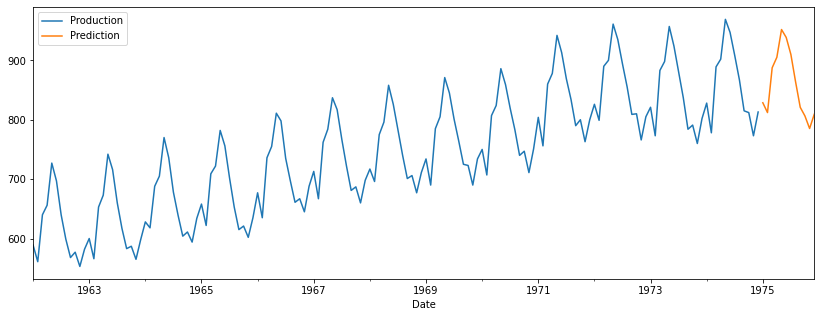

In [62]:
data_prod_predict_last_12.plot(figsize=(14,5))

In [63]:
data_prod_predict_last_12

,Production,Prediction
Date,,
1962-01-01,589.0,NaN
1962-02-01,561.0,NaN
1962-03-01,640.0,NaN
1962-04-01,656.0,NaN
1962-05-01,727.0,NaN
...,...,...
1975-08-01,NaN,863.962357
1975-09-01,NaN,820.918726
1975-10-01,NaN,806.395164


In [64]:
data_prod_predict_last_12['Number'] = n_input

In [65]:
data_prod_predict_last_12.head()

,Production,Prediction,Number
Date,,,
1962-01-01,589.0,NaN,12
1962-02-01,561.0,NaN,12
1962-03-01,640.0,NaN,12
1962-04-01,656.0,NaN,12
1962-05-01,727.0,NaN,12


In [66]:
data_final = data_prod_predict_last_12

In [67]:
data_final.reset_index('Date',inplace=True)

In [68]:
data_final.head(168)

,Date,Production,Prediction,Number
0,1962-01-01,589.0,NaN,12
1,1962-02-01,561.0,NaN,12
2,1962-03-01,640.0,NaN,12
3,1962-04-01,656.0,NaN,12
4,1962-05-01,727.0,NaN,12
...,...,...,...,...
163,1975-08-01,NaN,863.962357,12
164,1975-09-01,NaN,820.918726,12
165,1975-10-01,NaN,806.395164,12
166,1975-11-01,NaN,785.268106,12


In [69]:
data_final = data_final.where(pd.notnull(data_final), None)

In [70]:
data_final

,Date,Production,Prediction,Number
0,1962-01-01,589.0,None,12
1,1962-02-01,561.0,None,12
2,1962-03-01,640.0,None,12
3,1962-04-01,656.0,None,12
4,1962-05-01,727.0,None,12
...,...,...,...,...
163,1975-08-01,None,863.962357,12
164,1975-09-01,None,820.918726,12
165,1975-10-01,None,806.395164,12
166,1975-11-01,None,785.268106,12


In [71]:
for index, row in data_final.iterrows():
    created_at = row['Date']
    production = row['Production']
    prediction = row['Prediction']
    number = row['Number']
    
    sql = "INSERT INTO tb_prediction_sales (created_at, production, prediction, number) VALUES (%s, %s, %s, %s)"
    val = (created_at, production, prediction, number)
    print(val)
    
    cursor.execute(sql, val)
    db.commit()

(Timestamp('1962-01-01 00:00:00'), 589.0, None, 12)
(Timestamp('1962-02-01 00:00:00'), 561.0, None, 12)
(Timestamp('1962-03-01 00:00:00'), 640.0, None, 12)
(Timestamp('1962-04-01 00:00:00'), 656.0, None, 12)
(Timestamp('1962-05-01 00:00:00'), 727.0, None, 12)
(Timestamp('1962-06-01 00:00:00'), 697.0, None, 12)
(Timestamp('1962-07-01 00:00:00'), 640.0, None, 12)
(Timestamp('1962-08-01 00:00:00'), 599.0, None, 12)
(Timestamp('1962-09-01 00:00:00'), 568.0, None, 12)
(Timestamp('1962-10-01 00:00:00'), 577.0, None, 12)
(Timestamp('1962-11-01 00:00:00'), 553.0, None, 12)
(Timestamp('1962-12-01 00:00:00'), 582.0, None, 12)
(Timestamp('1963-01-01 00:00:00'), 600.0, None, 12)
(Timestamp('1963-02-01 00:00:00'), 566.0, None, 12)
(Timestamp('1963-03-01 00:00:00'), 653.0, None, 12)
(Timestamp('1963-04-01 00:00:00'), 673.0, None, 12)
(Timestamp('1963-05-01 00:00:00'), 742.0, None, 12)
(Timestamp('1963-06-01 00:00:00'), 716.0, None, 12)
(Timestamp('1963-07-01 00:00:00'), 660.0, None, 12)
(Timestamp('

(Timestamp('1975-08-01 00:00:00'), None, 863.9623565673829, 12)
(Timestamp('1975-09-01 00:00:00'), None, 820.9187259674072, 12)
(Timestamp('1975-10-01 00:00:00'), None, 806.3951644897461, 12)
(Timestamp('1975-11-01 00:00:00'), None, 785.2681064605713, 12)
(Timestamp('1975-12-01 00:00:00'), None, 809.2634124755859, 12)
